# 🧠 RLHF Full Workflow (Unified Notebook)
This notebook trains PPO Expert, generates preference data using π₁ vs π₂, trains PPO-RLHF using RewardNet, and then trains a DPO policy — all within one integrated flow. Supports both discrete and continuous environments.

## 📦 Step 1: Setup and Imports

In [2]:
import os
import gymnasium as gym
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.policies import ActorCriticPolicy


## ⚙️ Step 2: Environment Setup

In [4]:
# ===== 🧩 Parameter Settings: Used to control the entire training / preference / visualization process =====

env_id = "CartPole-v1"     # Task environment name (Options: CartPole-v1, Pendulum-v1, Acrobot-v1, MountainCar-v0, MountainCarContinuous-v0)

trajectory_seed = 42
seed = 2025                  # Random seed to ensure experiment reproducibility
# seed = 2024                  # Random seed to ensure experiment reproducibility
# seed = 42

total_timesteps = 40_000   # Number of training steps for Expert PPO (Recommended: 30k for CartPole, 300k for Pendulum)

num_prefs = 1000            # Number of preference samples
sample_prefs = 200
#sample_prefs = 1000
# num_epochs = 200         # Number of epochs for DPO

# ===========================================================

set_random_seed(seed)

env = Monitor(gym.make(env_id))
is_discrete = hasattr(env.action_space, "n")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
sample_length = 200
print(f"✅ Environment: {env_id} | Action space: {'Discrete' if is_discrete else 'Continuous'} | sample_length: {sample_length}")


✅ Environment: CartPole-v1 | Action space: Discrete | sample_length: 200


## 🧠 Step 3: Train PPO Expert (π₁) and Save Checkpoints

In [5]:
checkpoint_dir = f"./checkpoints_{env_id.replace('-', '_')}"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = CheckpointCallback(
    save_freq=total_timesteps // 10,
    save_path=checkpoint_dir,
    name_prefix="ppo"
)

expert_model = PPO("MlpPolicy", env, verbose=1, seed=trajectory_seed)
expert_model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)
expert_model.save(f"{env_id}_expert_seed{trajectory_seed}.zip")
env.close()


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 22       |
| time/              |          |
|    fps             | 6821     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 24.6        |
|    ep_rew_mean          | 24.6        |
| time/                   |             |
|    fps                  | 3938        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008349772 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_varia

## 🧪 Step 4: Select π₂ (Half-Performance PPO Checkpoint)

In [6]:
def evaluate_policy(model, env, episodes=10):
    scores = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        scores.append(total)
    return np.mean(scores)

env = gym.make(env_id)
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".zip")])
rewards = [(f, evaluate_policy(PPO.load(os.path.join(checkpoint_dir, f), env=env), env)) for f in checkpoints]
best_reward = max(rewards, key=lambda x: x[1])[1]
target = best_reward * 0.5
rewards.sort(key=lambda x: abs(x[1] - target))
pi2_model = PPO.load(os.path.join(checkpoint_dir, rewards[0][0]), env=env)
pi2_model.save(f"{env_id}_pi2_model_seed{trajectory_seed}.zip")
print(f"✅ Selected π₂: {rewards[0][0]} with ~{rewards[0][1]:.1f} reward")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Selected π₂: ppo_16000_steps.zip with ~289.9 reward


## ❤️ Step 5: Generate Preferences (π₁ vs π₂)

In [5]:
import numpy as np
import pickle
from tqdm import trange
import numpy as np

def generate_trajectory(model, env, seed, max_steps):
    obs_list, act_list, rewards, mask = [], [], [], []
    obs, _ = env.reset()

    for step in range(max_steps):
        action, _ = model.predict(obs)
        obs_, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        obs_list.append(np.array(obs))       # ensure obs is np.array
        act_list.append(np.array(action))    # ensure action is np.array
        rewards.append(reward)
        mask.append(1)

        obs = obs_
        if done:
            break

    pad_len = max_steps - len(obs_list)
    if pad_len > 0:
        obs_shape = obs_list[0].shape
        obs_list += [np.zeros(obs_shape)] * pad_len
        act_shape = act_list[0].shape if isinstance(act_list[0], np.ndarray) else ()
        act_list += [np.zeros(act_shape)] * pad_len
        rewards += [0.0] * pad_len
        mask += [0] * pad_len

    return {
        "obs": np.stack(obs_list),       # [T, obs_dim]
        "acts": np.stack(act_list),      # [T] (discrete) or [T, act_dim] (continuous)
        "rews": np.stack(rewards),       # [T]
        "mask": np.stack(mask)           # [T]
    }

def compute_return(traj):
    return sum(traj["rews"])

def soft_preference_prob(R1, R2):
    max_r = max(R1, R2)
    return np.exp(R1 - max_r) / (np.exp(R1 - max_r) + np.exp(R2 - max_r))

# Sample preference data
prefs = []
for idx in trange(num_prefs, desc="🔄 Generating preference pairs"):
    traj1 = generate_trajectory(model = expert_model, env=env, seed=idx, max_steps=sample_length)
    traj2 = generate_trajectory(model = pi2_model, env=env, seed=idx, max_steps=sample_length)
    R1, R2 = compute_return(traj1), compute_return(traj2)
    p = soft_preference_prob(R1, R2)
    label = int(np.random.rand() < p)
    prefs.append((traj1, traj2, label))

# save .pkl
filename = f"prefs_{env_id}_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump(prefs, f)

print(f"✅ Saved {len(prefs)} preference pairs to {filename}")

🔄 Generating preference pairs: 100%|██████████| 1000/1000 [01:34<00:00, 10.54it/s]

✅ Saved 1000 preference pairs to prefs_CartPole-v1_seed2025.pkl


In [7]:
class PreferenceDataset(torch.utils.data.Dataset):
    def __init__(self, prefs, is_discrete):
        self.prefs = prefs
        self.is_discrete = is_discrete

    def __len__(self):
        return len(self.prefs)

    def __getitem__(self, idx):
        traj1, traj2, label = self.prefs[idx]

        return {
            "obs1": torch.from_numpy(traj1["obs"]).float(),
            "acts1": torch.from_numpy(traj1["acts"]).long() if self.is_discrete else torch.from_numpy(traj1["acts"]).float(),
            "mask1": torch.from_numpy(traj1["mask"]).float(),

            "obs2": torch.from_numpy(traj2["obs"]).float(),
            "acts2": torch.from_numpy(traj2["acts"]).long() if self.is_discrete else torch.from_numpy(traj2["acts"]).float(),
            "mask2": torch.from_numpy(traj2["mask"]).float(),

            "label": torch.tensor(label, dtype=torch.float32)
        }

## ⚙️ Step 7: Train DPO Policy

In [8]:
expert_model = PPO.load(f"{env_id}_expert_seed{trajectory_seed}.zip", env=env)
pi2_model = PPO.load(f"{env_id}_pi2_model_seed{trajectory_seed}.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
class SharedPolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete, hidden_size=64):
        super().__init__()
        self.is_discrete = is_discrete
        if is_discrete:
            self.net = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
        else:
            self.mu = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
            self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs):
        if self.is_discrete:
            return self.net(obs)
        else:
            mu = self.mu(obs)
            std = self.log_std.exp().expand_as(mu)
            return mu, std

    def select_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            logits = self.forward(obs)
            probs = torch.softmax(logits, dim=-1)
            return probs.multinomial(num_samples=1).item()
        else:
            mu, std = self.forward(obs)
            dist = torch.distributions.Normal(mu, std)
            return dist.sample().squeeze(0).detach().numpy()


In [9]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO
import copy
def train_dpo_from_ref(dataloader,ref_policy_sb3, env, beta= 0.05,  seed=42, epochs=200, device='cpu'):
    torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]


    ref_policy = ref_policy_sb3.policy  # frozen
    policy = copy.deepcopy(ref_policy)  # trainable

    policy.to(device)
    ref_policy.to(device)
    ref_policy.eval()  # ensure frozen

    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        policy.train()  # ensure in training mode
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]
            obs1_flat = obs1.view(-1, obs_dim) # [B*T, obs_dim]
            obs2_flat = obs2.view(-1, obs_dim) # [B*T, obs_dim]
            acts1_flat = acts1.view(-1).long() if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1).long() if is_discrete else acts2.view(-1, act_dim)

            # --- Compute log probs from trainable policy ---

            dist1 = policy.get_distribution(obs1_flat)
            dist2 = policy.get_distribution(obs2_flat)

            logp1 = dist1.log_prob(acts1_flat)
            logp2 = dist2.log_prob(acts2_flat)



            #logp1 = torch.log_softmax(policy(obs1_flat), dim=-1)
            #logp2 = torch.log_softmax(policy(obs2_flat), dim=-1)

            # --- Compute log probs from reference policy (frozen) ---
            with torch.no_grad():
                dist1_ref = ref_policy.get_distribution(obs1_flat)
                dist2_ref = ref_policy.get_distribution(obs2_flat)

                logp1_ref = dist1_ref.log_prob(acts1_flat)
                logp2_ref = dist2_ref.log_prob(acts2_flat)

                #logp1_ref = torch.log_softmax(ref_policy(obs1_flat), dim=-1)
                #logp2_ref = torch.log_softmax(ref_policy(obs2_flat), dim=-1)


            lp1 = (logp1 - logp1_ref).view(B, -1)  # shape [B, T]
            lp2 = (logp2 - logp2_ref).view(B, -1)


            #lp1 = logp1[torch.arange(len(acts1_flat)), acts1_flat].view(B, -1)
            #lp2 = logp2[torch.arange(len(acts2_flat)), acts2_flat].view(B, -1)

            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits =beta*(logp1_sum - logp2_sum)        # [B]
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy



In [10]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO

def train_dpo(dataloader, env, seed=None, beta = 1, epochs=200, device='cpu'):
    if seed is not None:
        torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
    policy = SharedPolicyNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        policy.train()  # ensure in training mode
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]
            obs1_flat = obs1.view(-1, obs_dim) # [B*T, obs_dim]
            obs2_flat = obs2.view(-1, obs_dim) # [B*T, obs_dim]
            acts1_flat = acts1.view(-1).long() if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1).long() if is_discrete else acts2.view(-1, act_dim)

            logp1 = torch.log_softmax(policy(obs1_flat), dim=-1)
            logp2 = torch.log_softmax(policy(obs2_flat), dim=-1)
            lp1 = logp1[torch.arange(len(acts1_flat)), acts1_flat].view(B, -1)
            lp2 = logp2[torch.arange(len(acts2_flat)), acts2_flat].view(B, -1)

            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits = (logp1_sum - logp2_sum)        # [B]
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy

#with open(f"prefs_{env_id}_seed{trajectory_seed}.pkl", "rb") as f:
#    prefs = pickle.load(f)
#prefs = prefs[:200]
#
#dataset = PreferenceDataset(prefs, is_discrete)
#loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
#
#dpo_model = train_dpo(loader, env)
#torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/30, Loss: 0.6931
Epoch 2/30, Loss: 0.6931
Epoch 3/30, Loss: 0.6931
Epoch 4/30, Loss: 0.6931
Epoch 5/30, Loss: 0.6931
Epoch 6/30, Loss: 0.6931
Epoch 7/30, Loss: 0.6931
Epoch 8/30, Loss: 0.6931
Epoch 9/30, Loss: 0.6931
Epoch 10/30, Loss: 0.6931
Epoch 11/30, Loss: 0.6931
Epoch 12/30, Loss: 0.6931
Epoch 13/30, Loss: 0.6931
Epoch 14/30, Loss: 0.6931
Epoch 15/30, Loss: 0.6931
Epoch 16/30, Loss: 0.6931
Epoch 17/30, Loss: 0.6931
Epoch 18/30, Loss: 0.6931
Epoch 19/30, Loss: 0.6931
Epoch 20/30, Loss: 0.6931
Epoch 21/30, Loss: 0.6931
Epoch 22/30, Loss: 0.6931
Epoch 23/30, Loss: 0.6931
Epoch 24/30, Loss: 0.6931
Epoch 25/30, Loss: 0.6931
Epoch 26/30, Loss: 0.6931
Epoch 27/30, Loss: 0.6931
Epoch 28/30, Loss: 0.6931
Epoch 29/30, Loss: 0.6931
Epoch 30/30, Loss: 0.6931
Final avg reward for β = 0.0: 457.00
Training DPO (π₂ → Expert) with β = 0.01
Epoch 1/30, Loss: 0.6779
Epoch 2/30, Loss: 0.6561
Epoch 3/30, Loss: 0.6380
Epoch 4/30, Loss: 0.6333
Epoch 5/30,

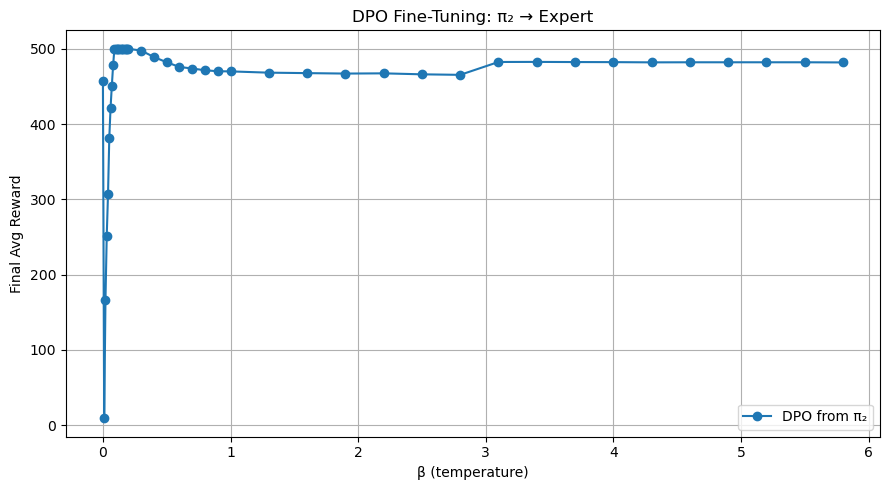

--------------------------------we use beta = 0.09
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/30, Loss: 0.6931
Epoch 2/30, Loss: 0.6931
Epoch 3/30, Loss: 0.6931
Epoch 4/30, Loss: 0.6931
Epoch 5/30, Loss: 0.6931
Epoch 6/30, Loss: 0.6931
Epoch 7/30, Loss: 0.6931
Epoch 8/30, Loss: 0.6931
Epoch 9/30, Loss: 0.6931
Epoch 10/30, Loss: 0.6931
Epoch 11/30, Loss: 0.6931
Epoch 12/30, Loss: 0.6931
Epoch 13/30, Loss: 0.6931
Epoch 14/30, Loss: 0.6931
Epoch 15/30, Loss: 0.6931
Epoch 16/30, Loss: 0.6931
Epoch 17/30, Loss: 0.6931
Epoch 18/30, Loss: 0.6931
Epoch 19/30, Loss: 0.6931
Epoch 20/30, Loss: 0.6931
Epoch 21/30, Loss: 0.6931
Epoch 22/30, Loss: 0.6931
Epoch 23/30, Loss: 0.6931
Epoch 24/30, Loss: 0.6931
Epoch 25/30, Loss: 0.6931
Epoch 26/30, Loss: 0.6931
Epoch 27/30, Loss: 0.6931
Epoch 28/30, Loss: 0.6931
Epoch 29/30, Loss: 0.6931
Epoch 30/30, Loss: 0.6931
Final avg reward for β = 0.0: 457.00
Training DPO (π₂ → Expert) with β = 0.01
Epoch 1/30, Loss: 0.6745
Epoch 2/30, Loss: 0.6595
Epoch 3/30

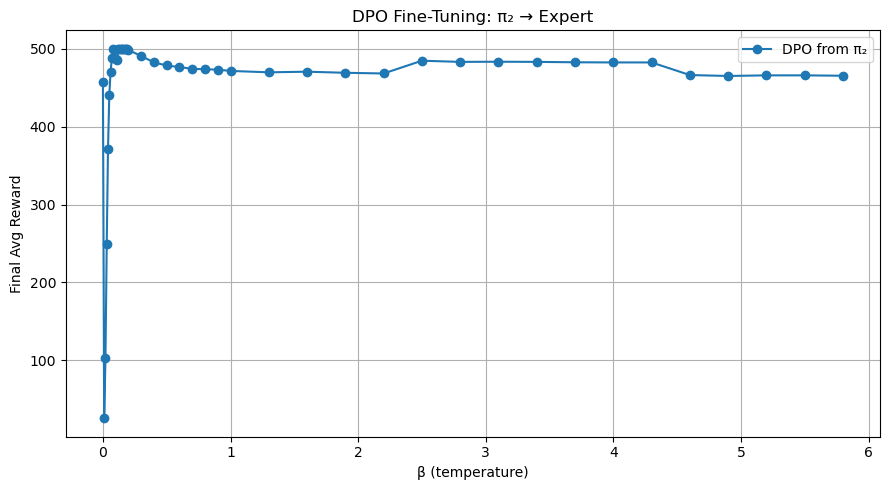

--------------------------------we use beta = 0.08
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/30, Loss: 0.6931
Epoch 2/30, Loss: 0.6931
Epoch 3/30, Loss: 0.6931
Epoch 4/30, Loss: 0.6931
Epoch 5/30, Loss: 0.6931
Epoch 6/30, Loss: 0.6931
Epoch 7/30, Loss: 0.6931
Epoch 8/30, Loss: 0.6931
Epoch 9/30, Loss: 0.6931
Epoch 10/30, Loss: 0.6931
Epoch 11/30, Loss: 0.6931
Epoch 12/30, Loss: 0.6931
Epoch 13/30, Loss: 0.6931
Epoch 14/30, Loss: 0.6931
Epoch 15/30, Loss: 0.6931
Epoch 16/30, Loss: 0.6931
Epoch 17/30, Loss: 0.6931
Epoch 18/30, Loss: 0.6931
Epoch 19/30, Loss: 0.6931
Epoch 20/30, Loss: 0.6931
Epoch 21/30, Loss: 0.6931
Epoch 22/30, Loss: 0.6931
Epoch 23/30, Loss: 0.6931
Epoch 24/30, Loss: 0.6931
Epoch 25/30, Loss: 0.6931
Epoch 26/30, Loss: 0.6931
Epoch 27/30, Loss: 0.6931
Epoch 28/30, Loss: 0.6931
Epoch 29/30, Loss: 0.6931
Epoch 30/30, Loss: 0.6931
Final avg reward for β = 0.0: 457.00
Training DPO (π₂ → Expert) with β = 0.01
Epoch 1/30, Loss: 0.6765
Epoch 2/30, Loss: 0.6698
Epoch 3/30

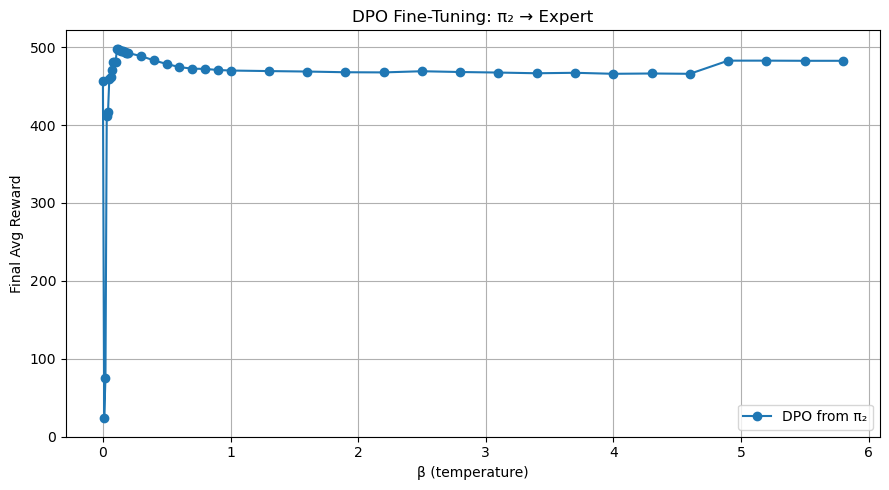

--------------------------------we use beta = 0.11
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/30, Loss: 0.6931
Epoch 2/30, Loss: 0.6931
Epoch 3/30, Loss: 0.6931
Epoch 4/30, Loss: 0.6931
Epoch 5/30, Loss: 0.6931
Epoch 6/30, Loss: 0.6931
Epoch 7/30, Loss: 0.6931
Epoch 8/30, Loss: 0.6931
Epoch 9/30, Loss: 0.6931
Epoch 10/30, Loss: 0.6931
Epoch 11/30, Loss: 0.6931
Epoch 12/30, Loss: 0.6931
Epoch 13/30, Loss: 0.6931
Epoch 14/30, Loss: 0.6931
Epoch 15/30, Loss: 0.6931
Epoch 16/30, Loss: 0.6931
Epoch 17/30, Loss: 0.6931
Epoch 18/30, Loss: 0.6931
Epoch 19/30, Loss: 0.6931
Epoch 20/30, Loss: 0.6931
Epoch 21/30, Loss: 0.6931
Epoch 22/30, Loss: 0.6931
Epoch 23/30, Loss: 0.6931
Epoch 24/30, Loss: 0.6931
Epoch 25/30, Loss: 0.6931
Epoch 26/30, Loss: 0.6931
Epoch 27/30, Loss: 0.6931
Epoch 28/30, Loss: 0.6931
Epoch 29/30, Loss: 0.6931
Epoch 30/30, Loss: 0.6931
Final avg reward for β = 0.0: 457.00
Training DPO (π₂ → Expert) with β = 0.01
Epoch 1/30, Loss: 0.6734
Epoch 2/30, Loss: 0.6644
Epoch 3/30

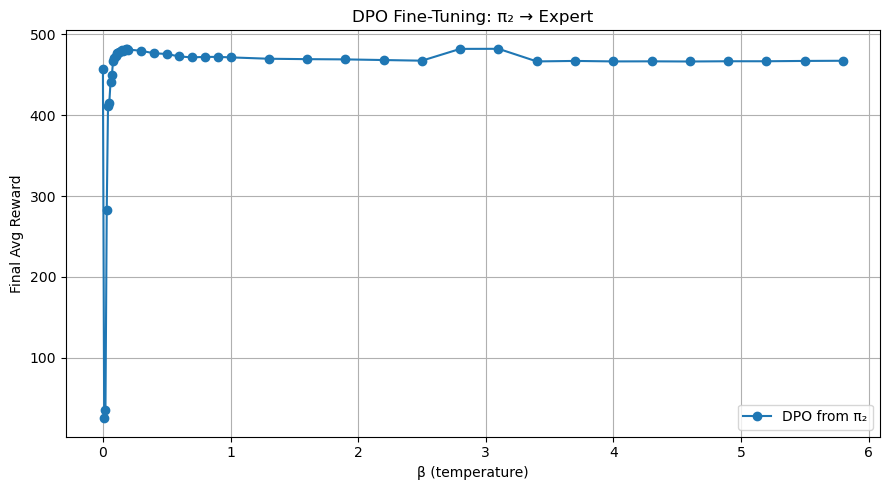

--------------------------------we use beta = 3.1000000000000005
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/30, Loss: 0.6931
Epoch 2/30, Loss: 0.6931
Epoch 3/30, Loss: 0.6931
Epoch 4/30, Loss: 0.6931
Epoch 5/30, Loss: 0.6931
Epoch 6/30, Loss: 0.6931
Epoch 7/30, Loss: 0.6931
Epoch 8/30, Loss: 0.6931
Epoch 9/30, Loss: 0.6931
Epoch 10/30, Loss: 0.6931
Epoch 11/30, Loss: 0.6931
Epoch 12/30, Loss: 0.6931
Epoch 13/30, Loss: 0.6931
Epoch 14/30, Loss: 0.6931
Epoch 15/30, Loss: 0.6931
Epoch 16/30, Loss: 0.6931
Epoch 17/30, Loss: 0.6931
Epoch 18/30, Loss: 0.6931
Epoch 19/30, Loss: 0.6931
Epoch 20/30, Loss: 0.6931
Epoch 21/30, Loss: 0.6931
Epoch 22/30, Loss: 0.6931
Epoch 23/30, Loss: 0.6931
Epoch 24/30, Loss: 0.6931
Epoch 25/30, Loss: 0.6931
Epoch 26/30, Loss: 0.6931
Epoch 27/30, Loss: 0.6931
Epoch 28/30, Loss: 0.6931
Epoch 29/30, Loss: 0.6931
Epoch 30/30, Loss: 0.6931
Final avg reward for β = 0.0: 457.00
Training DPO (π₂ → Expert) with β = 0.01
Epoch 1/30, Loss: 0.6662
Epoch 2/30, Loss: 0.6

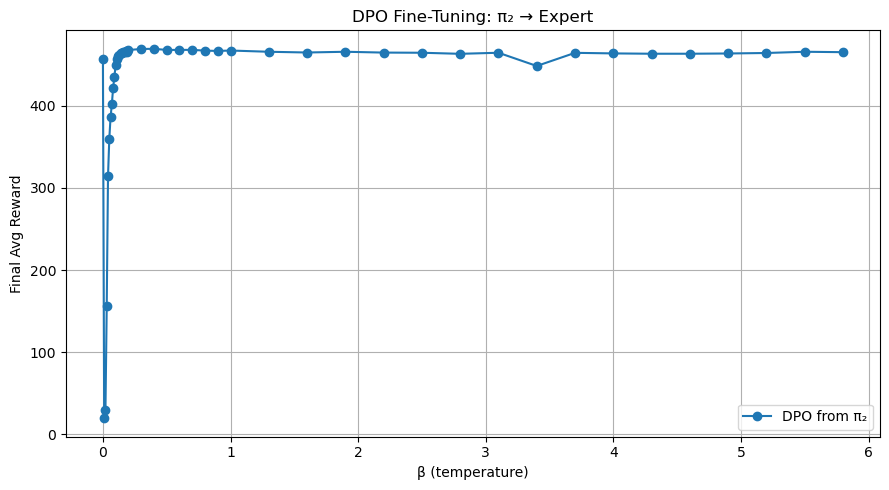

--------------------------------we use beta = 0.4000000000000001


In [37]:
import matplotlib.pyplot as plt

def eval_policy(model, env, is_sb3=True, episodes=20):
    returns = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns



import matplotlib.pyplot as plt
import numpy as np

def fine_tune_dpo_with_betas(env, dataloader, pi2_model, beta_values_from_ref, epochs=30, device='cpu'):
    rewards_from_ref = {}

    obs_dim = env.observation_space.shape[0]
    is_discrete = hasattr(env.action_space, "n")
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]

    # ✅ Train DPO starting from π₂ and moving toward expert
    for beta in beta_values_from_ref:
        print(f"Training DPO (π₂ → Expert) with β = {beta}")

        trained_policy_from_ref = train_dpo_from_ref(
            dataloader=dataloader,
            ref_policy_sb3=pi2_model,
            env=env,
            beta=beta,
            epochs=epochs,
            device=device
        )

        avg_reward = np.mean(eval_policy(trained_policy_from_ref, env, episodes=10))
        print(f"Final avg reward for β = {beta}: {avg_reward:.2f}")
        rewards_from_ref[beta] = avg_reward


    # ✅ Plot both curves
    plt.figure(figsize=(9, 5))
    plt.plot(list(rewards_from_ref.keys()), list(rewards_from_ref.values()), marker='o', label="DPO from π₂")
    plt.xlabel("β (temperature)")
    plt.ylabel("Final Avg Reward")
    plt.title("DPO Fine-Tuning: π₂ → Expert")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rewards_from_ref



sample_prefs = [200,400,600,800,1000]
rewards = []
filename = f"prefs_{env_id}_seed{seed}.pkl"
for sample_pref in sample_prefs:
    with open(filename, "rb") as f:
        prefs = pickle.load(f)

    prefs = prefs[:sample_pref]

    dataset = PreferenceDataset(prefs, is_discrete)
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

    beta_values_from_ref =np.concatenate([np.arange(0,0.2, 0.01) , np.arange(0.2, 1, 0.1), np.arange(1, 6, 0.3)])
    # we could also potentially choose an adaptive beta, like : beta = beta_init * (epoch / max_epochs)

    rewards_from_ref = fine_tune_dpo_with_betas(env, loader, pi2_model,beta_values_from_ref)
    rewards.append(rewards_from_ref)
    beta_from_ref = max(rewards_from_ref, key = rewards_from_ref.get)
    #beta_from_ref = 0.5
    print(f"--------------------------------we use beta = {beta_from_ref}")

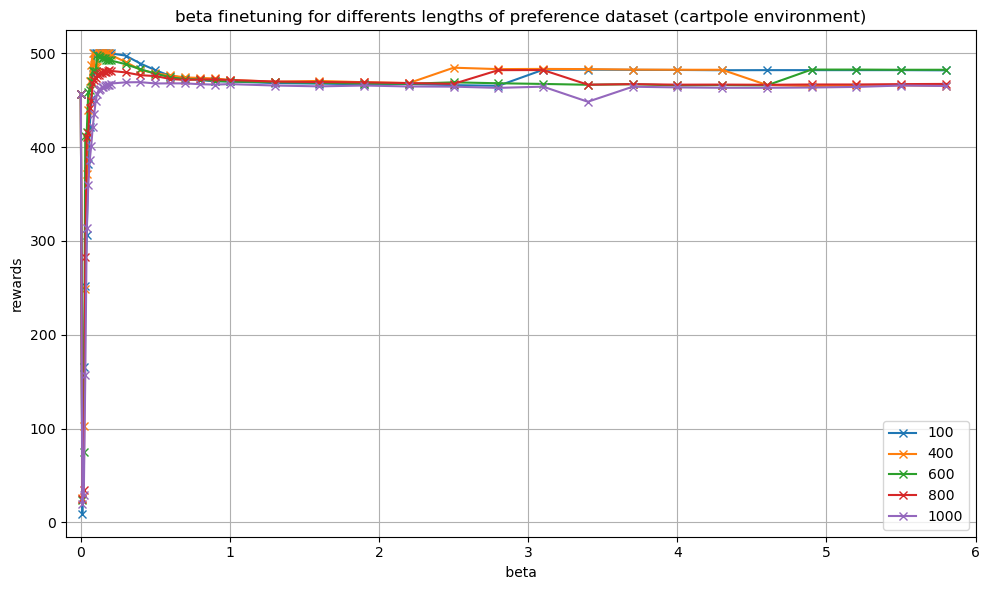

In [39]:
plt.figure(figsize=(10, 6))
sample_prefs = [100,400,600,800,1000]

# Loop through each dictionary and create a scatter plot
for i, reward_dict in enumerate(rewards):
    x = list(reward_dict.keys())
    y = list(reward_dict.values())
    plt.plot(x, y, label=f'{sample_prefs[i]}', marker='x')

# Configure the plot
plt.title("beta finetuning for differents lengths of preference dataset (cartpole environment)")
plt.xlabel(" beta ")
plt.xlim((-0.1,6))
plt.ylabel("rewards")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
dpo_model_from_ref = train_dpo_from_ref(loader,pi2_model, env, beta=beta_from_ref, seed=seed)
torch.save(dpo_model_from_ref.state_dict(), f"{env_id}_dpo_pi2_seed{seed}.pth")

dpo_model = train_dpo(loader, env, seed=seed)
torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

Epoch 1/200, Loss: 0.9296
Epoch 2/200, Loss: 0.7292
Epoch 3/200, Loss: 0.6927
Epoch 4/200, Loss: 0.6799
Epoch 5/200, Loss: 0.8197
Epoch 6/200, Loss: 0.8392
Epoch 7/200, Loss: 0.6503
Epoch 8/200, Loss: 0.7253
Epoch 9/200, Loss: 0.7333
Epoch 10/200, Loss: 0.7276
Epoch 11/200, Loss: 0.7206
Epoch 12/200, Loss: 0.8384
Epoch 13/200, Loss: 0.6588
Epoch 14/200, Loss: 0.7652
Epoch 15/200, Loss: 0.6980
Epoch 16/200, Loss: 0.7164
Epoch 17/200, Loss: 0.6678
Epoch 18/200, Loss: 0.9461
Epoch 19/200, Loss: 0.8403
Epoch 20/200, Loss: 0.8619
Epoch 21/200, Loss: 0.6902
Epoch 22/200, Loss: 0.6384
Epoch 23/200, Loss: 0.7103
Epoch 24/200, Loss: 0.6166
Epoch 25/200, Loss: 0.7974
Epoch 26/200, Loss: 0.7348
Epoch 27/200, Loss: 0.6822
Epoch 28/200, Loss: 0.6682
Epoch 29/200, Loss: 0.6790
Epoch 30/200, Loss: 0.6861
Epoch 31/200, Loss: 0.9383
Epoch 32/200, Loss: 0.7120
Epoch 33/200, Loss: 0.8001
Epoch 34/200, Loss: 0.6889
Epoch 35/200, Loss: 0.7772
Epoch 36/200, Loss: 0.7797
Epoch 37/200, Loss: 0.6569
Epoch 38/2

## 🧠 Step 8: Train RewardNet from Preferences (for PPO-RLHF)

In [13]:
class RewardNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete=True, hidden_size=64):
        super().__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.is_discrete = is_discrete
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, states, actions):
        if self.is_discrete:
            one_hot = F.one_hot(actions.view(-1), num_classes=self.act_dim).float()
            x = torch.cat([states, one_hot], dim=-1)
        else:
            x = torch.cat([states, actions], dim=-1)
        return self.net(x).squeeze(-1)

def train_reward_model(dataloader, obs_dim, act_dim, is_discrete, epochs=200, lr=1e-3, seed = None, device='cpu'):
    if seed is not None:
        torch.manual_seed(seed)
        
    model = RewardNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            r1 = model(obs1.view(-1, obs_dim), acts1.view(-1) if is_discrete else acts1.view(-1, act_dim))
            r2 = model(obs2.view(-1, obs_dim), acts2.view(-1) if is_discrete else acts2.view(-1, act_dim))

            r1 = r1.view(obs1.shape[0], obs1.shape[1]) * mask1
            r2 = r2.view(obs2.shape[0], obs2.shape[1]) * mask2

            r1_sum = r1.sum(dim=1)  # [B]
            r2_sum = r2.sum(dim=1)  # [B]

            logits = r1_sum - r2_sum  # [B]
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:sample_prefs]

dataset = PreferenceDataset(prefs, is_discrete=is_discrete)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

reward_model = train_reward_model(loader, obs_dim, act_dim, is_discrete, seed=seed)
torch.save(reward_model.state_dict(), f"{env_id}_reward_model_seed{seed}_dataset{sample_prefs}.pth")


TypeError: slice indices must be integers or None or have an __index__ method

## 🔁 Step 9: Train PPO-RLHF (Reward Finetuned from Expert π₁)

In [14]:
import gymnasium as gym
from gymnasium import Wrapper

class RewardNetWrapper(Wrapper):
    def __init__(self, env, reward_net, is_discrete):
        super().__init__(env)
        self.reward_net = reward_net
        self.is_discrete = is_discrete

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Convert to tensor
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            act_tensor = torch.tensor(action, dtype=torch.long).unsqueeze(0)
        else:
            act_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

        # Predict learned reward
        with torch.no_grad():
            reward = self.reward_net(obs_tensor, act_tensor).item()

        return obs, reward, terminated, truncated, info

# Wrap the environment with the trained reward_net
reward_model.eval()  # Ensure the model is in inference mode
env = RewardNetWrapper(gym.make(env_id), reward_model, is_discrete)
env = Monitor(env)

num_epochs = 200
# Retrain the policy using the new reward
rlhf_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
rlhf_model.learn(total_timesteps=num_epochs * sample_prefs)
# the total step should be the same as the DPO
rlhf_model.save(f"{env_id}_rlhf_seed{seed}_dataset{sample_prefs}_dataset{sample_prefs}.zip")


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.7     |
|    ep_rew_mean     | 6.99     |
| time/              |          |
|    fps             | 5887     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.7        |
|    ep_rew_mean          | 9.55        |
| time/                   |             |
|    fps                  | 4226        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012383912 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_varia

## 📊 Step 10: Compare PPO Expert vs PPO-RLHF vs DPO vs PI2 vs DPO from PI2

<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_1132/1073025612.py:31: SyntaxWarning: invalid escape sequence '\p'
  labels=["Expert ($\pi_1$)", "RLHF", "DPO", "$\pi_2$", "DPO from $\pi_2$"],
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_1132/1073025612.py:31: SyntaxWarning: invalid escape sequence '\p'
  labels=["Expert ($\pi_1$)", "RLHF", "DPO", "$\pi_2$", "DPO from $\pi_2$"],
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_1132/1073025612.py:31: SyntaxWarning: invalid escape sequence '\p'
  labels=["Expert ($\pi_1$)", "RLHF", "DPO", "$\pi_2$", "DPO from $\pi_2$"],


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_1132/1073025612.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([returns_expert, returns_rlhf, returns_dpo, returns_pi2, returns_dpo_from_pi2],
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_1132/1073025612.py:39: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_1132/1073025612.py:40: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{env_id}_benchmark_{seed}_dataset{sample_prefs}.png", dpi=300)
/Users/mathis/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


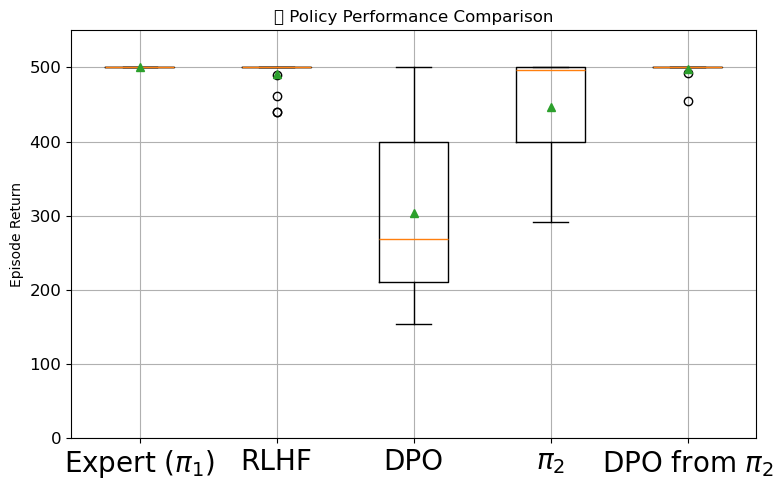

In [15]:
def eval_policy(model, env, is_sb3=True, episodes=20):
    returns = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns

import copy
env = gym.make(env_id)
returns_expert = eval_policy(PPO.load(f"{env_id}_expert_seed{trajectory_seed}.zip", env=env), env)
returns_rlhf   = eval_policy(PPO.load(f"{env_id}_rlhf_seed{seed}_dataset{sample_prefs}_dataset{sample_prefs}.zip", env=env), env)
dpo_model = SharedPolicyNet(obs_dim, act_dim, is_discrete)
dpo_model.load_state_dict(torch.load(f"{env_id}_dpo_seed{seed}.pth"))
returns_dpo  = eval_policy(dpo_model, env, is_sb3=False)
pi2_model = PPO.load(f"{env_id}_pi2_model_seed{trajectory_seed}.zip", env=env)
returns_pi2 = eval_policy(pi2_model, env)
dpo_from_pi2 = copy.deepcopy(pi2_model.policy)
dpo_from_pi2.load_state_dict(torch.load(f"{env_id}_dpo_pi2_seed{seed}.pth"))
returns_dpo_from_pi2 = eval_policy(dpo_from_pi2, env)


plt.figure(figsize=(8, 5))
plt.boxplot([returns_expert, returns_rlhf, returns_dpo, returns_pi2, returns_dpo_from_pi2],
            labels=["Expert ($\pi_1$)", "RLHF", "DPO", "$\pi_2$", "DPO from $\pi_2$"],
            showmeans=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.ylim(0, 550)
plt.title("🎯 Policy Performance Comparison")
plt.ylabel("Episode Return")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{env_id}_benchmark_{seed}_dataset{sample_prefs}.png", dpi=300)
plt.show()

<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_1132/3950601950.py:66: SyntaxWarning: invalid escape sequence '\p'
  titles = ["Expert", "$\pi_2$", "RLHF", "DPO", "DPO from $\pi_2$"]
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_1132/3950601950.py:66: SyntaxWarning: invalid escape sequence '\p'
  titles = ["Expert", "$\pi_2$", "RLHF", "DPO", "DPO from $\pi_2$"]


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


✅ GIF saved to: /Users/mathis/Master/RL/project/yule/EE-568-RL/CartPole-v1_comparison_seed2025_dataset200.gif


[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]


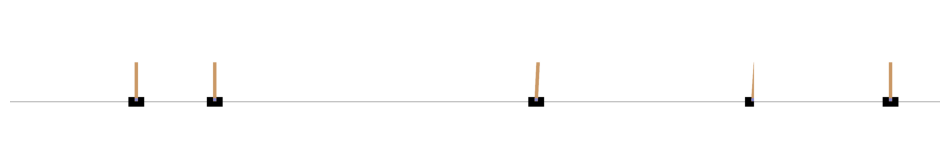

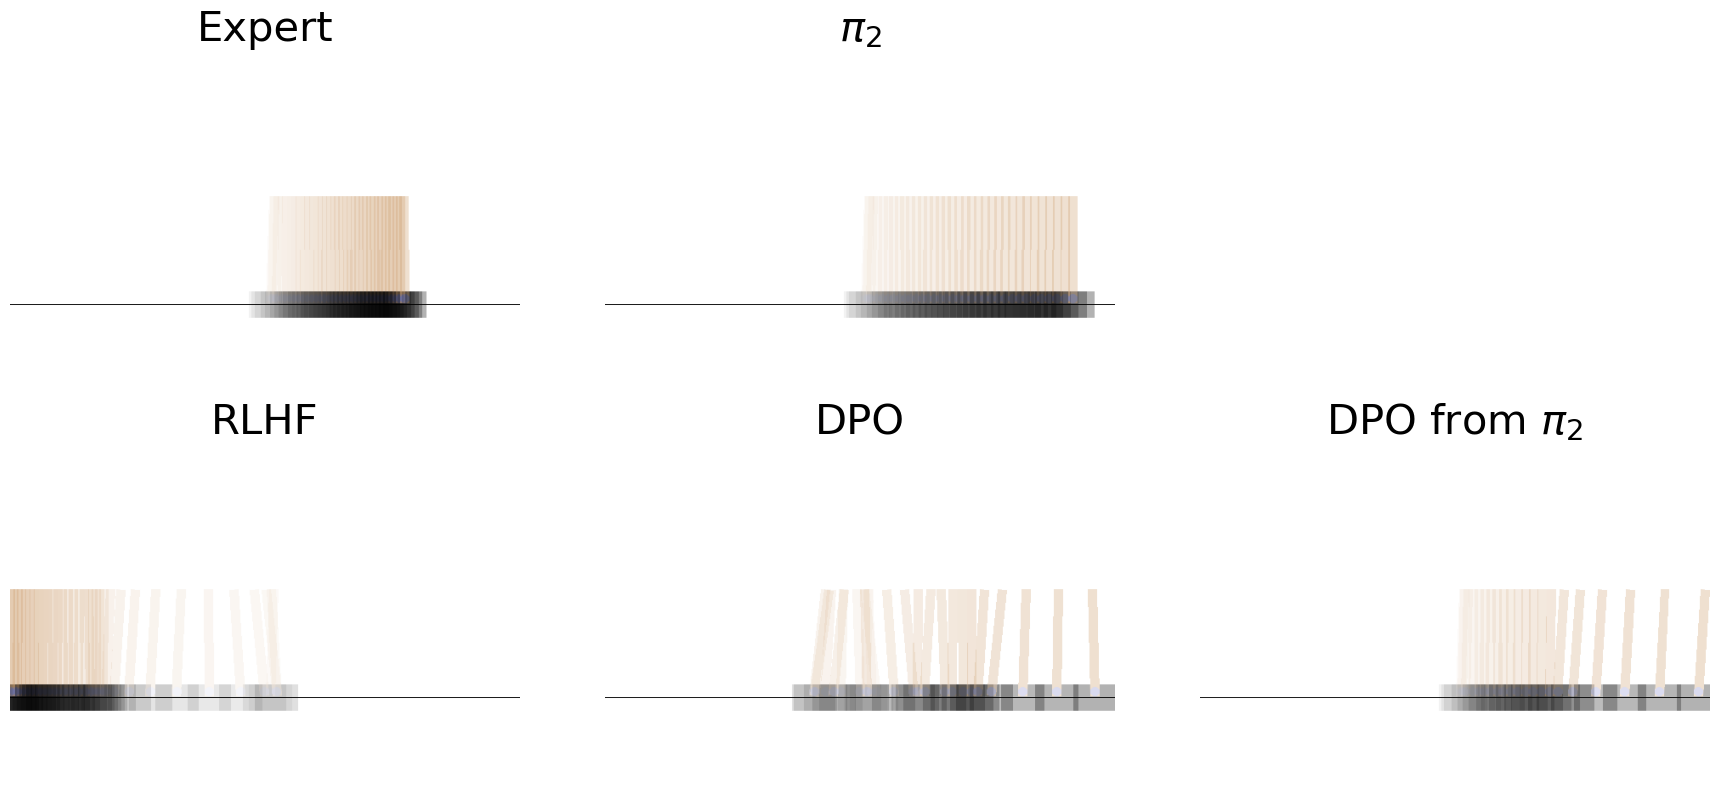

In [16]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from stable_baselines3 import PPO
import os

# Step 1: Run a single episode and record rendered frames
def record_episode(model, env, is_sb3=True, seed=None, max_steps=1000):
    frames = []
    obs, _ = env.reset(seed=seed)
    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    return frames

# Step 2: Combine multiple frame sequences into a single animation and optionally save as a GIF
def show_combined_animation(frames_list, fps=30, gif_path=None):
    min_len = min(len(f) for f in frames_list)
    fig = plt.figure(figsize=(12, 4))
    plt.axis('off')
    init_frame = np.hstack([f[0] for f in frames_list])
    im = plt.imshow(init_frame)

    def update(i):
        combined = np.hstack([f[i] for f in frames_list])
        im.set_array(combined)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=min_len, interval=1000/fps)

    if gif_path:
        ani.save(gif_path, writer='pillow', fps=fps)
        print(f"✅ GIF saved to: {os.path.abspath(gif_path)}")

    return HTML(ani.to_jshtml())

def trajectory_overlay_faded(frames, threshold=30, min_alpha=0.05, max_alpha=0.3):
    frames = [f.astype(np.float32) for f in frames]
    H, W, C = frames[0].shape

    overlay = np.ones((H, W, C), dtype=np.float32) * 255
    num_frames = len(frames)

    for idx, frame in enumerate(frames):
        diff = np.abs(frame - 255)
        mask = (diff.mean(axis=2) > threshold)

        alpha = min_alpha + (max_alpha - min_alpha) * (idx / (num_frames - 1))

        for c in range(3):
            overlay[:, :, c][mask] = (
                alpha * frame[:, :, c][mask] +
                (1 - alpha) * overlay[:, :, c][mask]
            )
    return np.clip(overlay, 0, 255).astype(np.uint8)

def show_trajectory_comparison(img_expert, img_dpo_from_pi2, img_rlhf, img_dpo, img_pi2, titles=None):
    if titles is None:
        titles = ["Expert", "$\pi_2$", "RLHF", "DPO", "DPO from $\pi_2$"]

    fig, axes = plt.subplots(2, 3, figsize=(18, 8) )
    axes = axes.flatten().tolist()
    fig.delaxes(axes[2])  # Remove the third axis (empty)
    axes = axes[:2] + axes[3:]  # Remove the empty axis
    print(axes)
    
    images = [img_expert, img_pi2, img_rlhf, img_dpo, img_dpo_from_pi2]
    for i, (ax, img, title) in enumerate(zip(axes, images, titles)):
        ax.imshow(img)
        ax.set_title(title, fontsize=30)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{env_id}_render_{seed}_dataset{sample_prefs}.png", dpi=300)
    plt.show()
    
# Step 3: Load models and environments
env_expert = gym.make(env_id, render_mode="rgb_array")
env_rlhf   = gym.make(env_id, render_mode="rgb_array")
env_dpo    = gym.make(env_id, render_mode="rgb_array")
env_pi2 = gym.make(env_id, render_mode="rgb_array")
env_dpo_from_pi2 = gym.make(env_id, render_mode="rgb_array")
expert_model = PPO.load(f"{env_id}_expert_seed{trajectory_seed}.zip", env=env_expert)
rlhf_model   = PPO.load(f"{env_id}_rlhf_seed{seed}_dataset{sample_prefs}_dataset{sample_prefs}", env=env_rlhf)
dpo_model = SharedPolicyNet(obs_dim, act_dim, is_discrete)
dpo_model.load_state_dict(torch.load(f"{env_id}_dpo_seed{seed}.pth"))
pi2_model = PPO.load(f"{env_id}_pi2_model_seed{trajectory_seed}.zip", env=env_pi2)
dpo_from_pi2 = copy.deepcopy(pi2_model.policy)
dpo_from_pi2.load_state_dict(torch.load(f"{env_id}_dpo_pi2_seed{seed}.pth"))

# Step 4: Collect animation frames for all three strategies
frames_expert = record_episode(expert_model, env_expert, seed=seed)
frames_rlhf   = record_episode(rlhf_model, env_rlhf, seed=seed)
frames_dpo    = record_episode(dpo_model, env_dpo, is_sb3=False, seed=seed)
frames_pi2 = record_episode(pi2_model, env_pi2, seed=seed)
frames_dpo_from_pi2 = record_episode(dpo_from_pi2, env_dpo_from_pi2, seed=seed)

# Step 5: Display the combined animation and save it as a GIF file
display(HTML("<h3>🎯 Strategy Animation Comparison: PPO Expert vs RLHF vs DPO vs PI2 vs DPO_PI2</h3>"))
display(show_combined_animation(
    [frames_expert, frames_rlhf, frames_dpo, frames_pi2, frames_dpo_from_pi2],
    gif_path=f"{env_id}_comparison_seed{seed}_dataset{sample_prefs}.gif"
))

img_expert = trajectory_overlay_faded(frames_expert[::15], threshold=55)
img_rlhf = trajectory_overlay_faded(frames_rlhf[::15], threshold=55)
img_dpo = trajectory_overlay_faded(frames_dpo[::15], threshold=55)
img_pi2 = trajectory_overlay_faded(frames_pi2[::15], threshold=55)
img_dpo_from_pi2 = trajectory_overlay_faded(frames_dpo_from_pi2[::15], threshold=55)
show_trajectory_comparison(img_expert, img_pi2, img_rlhf, img_dpo, img_dpo_from_pi2)
